In [626]:
# These libraries are pre-installed in SN Labs. If running in another environment please uncomment lines below to install them:
#!pip install --force-reinstall ibm_db==3.1.0 ibm_db_sa==0.3.3
# # Ensure we don't load_ext with sqlalchemy>=1.4 (incompadible)
# !pip uninstall sqlalchemy==1.4 -y && pip install sqlalchemy==1.3.24

!pip install --upgrade ipython-sql
!pip install --upgrade sqlalchemy
!pip install --upgrade ibm_db_sa

In [627]:
from google.colab import drive
drive.mount('/content/drive')
donor_path = "/content/drive/My Drive/DonorDetection/data/Csoaf_Donors.csv"
non_donor_path = "/content/drive/My Drive/DonorDetection/data/Csoaf_Non_Donors.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [628]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [629]:
# read data
donor_df = pd.read_csv(donor_path)
nondonor_df = pd.read_csv(non_donor_path)
donor_df.head()

,First Name,Last Name,Email,City,State,Country,Donation Amount,Income Level,Gender,Phone,...,Education Level,Facebook Profile,Website URL,LindIn Profile,Twitter Profile,Communication Preferences - Preferred methods of communication,Motivation For Donating,Donation Method,Number of events participation,Street Address
0,Jai Lin,Patterson,jai-lin@themill.com,Los Angeles,CA,United State,$500,20K,F,(830) 885-2767,...,Bachelor's degree,NaN,NaN,https://www.linkedin.com/in/jai-lin-patterson-...,NaN,Email,Network Opportunities,Cash,5,1008 W 24th St Apt 102
1,Alejandro,Vazquez,alejandro.vazquez@latimes.com,Los Angeles,CA,United State,"$1,000",100K,M,(213) 748-2858,...,"Bachelor's degree, Journalism",NaN,NaN,https://www.linkedin.com/in/alexuez/,NaN,Email,Personal satisfaction,Cash,3,1012 E 22nd St
2,Dylan,Holvey,nutrition@glwd.org,Los Angeles,CA,United State,$850,50K,M,(310) 839-4338,...,Bachelor of Arts,NaN,NaN,https://www.linkedin.com/in/dylan-holvey-87452...,NaN,Social media,Personal satisfaction,Cash,8,"4650 Sunset Blvd, Los Angeles, CA 90027, Unite..."
3,Matthew,Goodman,matthew@bigfooters.co,Los Angeles,CA,United State,$300,30K,M,(310) 470-2998,...,Others,NaN,NaN,https://www.linkedin.com/in/matthewgoodmannerd/,NaN,Social media,Recognition,Online,19,10730 Wellworth Ave
4,Zane,Burrows,aanouna@gametogenics.com,Los Angeles,CA,United State,$200,40K,M,(310) 472-3246,...,Others,NaN,NaN,https://www.linkedin.com/in/zane-burrows-50325...,NaN,Social media,Tax benefit,Check,5,1118 Somera Rd


In [630]:
import ibm_db

In [631]:
# #Replace the placeholder values with your actual Db2 hostname, username, and password:
# dsn_hostname = "21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud" # e.g.: "54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud"
# dsn_uid = "byn67890"        # e.g. "abc12345"
# dsn_pwd = "6SNL77PqgnJ7v25Z"      # e.g. "7dBZ3wWt9XN6$o0J"

# dsn_driver = "{IBM DB2 ODBC DRIVER}"
# dsn_database = "bludb"            # e.g. "BLUDB"
# dsn_port = "31864"                # e.g. "32733"
# dsn_protocol = "TCPIP"            # i.e. "TCPIP"
# dsn_security = "SSL"              #i.e. "SSL"

In [632]:
# #DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
# #Create the dsn connection string
# dsn = (
#     "DRIVER={0};"
#     "DATABASE={1};"
#     "HOSTNAME={2};"
#     "PORT={3};"
#     "PROTOCOL={4};"
#     "UID={5};"
#     "PWD={6};"
#     "SECURITY={7};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd,dsn_security)

# #print the connection string to check correct values are specified
# print(dsn)

In [633]:
# #DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
# #Create database connection

# try:
#     conn = ibm_db.connect(dsn, "", "")
#     print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

# except:
#     print ("Unable to connect: ", ibm_db.conn_errormsg() )

In [634]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [635]:
# Remember the connection string is of the format:
# %sql ibm_db_sa://my-username:my-password@hostname:port/BLUDB?security=SSL
# Enter the connection string for your Db2 on Cloud database instance below
# i.e. copy after db2:// from the URI string in Service Credentials of your Db2 instance. Remove the double quotes at the end.
#%sql ibm_db_sa://byn67890:6SNL77PqgnJ7v25Z@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
%sql ibm_db_sa://byn67890:6SNL77PqgnJ7v25Z@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL

In [636]:
# works here: https://www.coursera.org/learn/sql-data-science/ungradedLti/uCNuW/optional-db2-lab-analyzing-a-real-world-data-set
# %sql PERSIST donor_df

In [637]:
%sql select TABSCHEMA, TABNAME, CREATE_TIME from SYSCAT.TABLES where TABSCHEMA='byn67890'

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.


tabschema,tabname,create_time


In [638]:
%sql ALTER TABLE CSOAF_DONORS DROP COLUMN CLASS
%sql ALTER TABLE CSOAF_NON_DONORS DROP COLUMN CLASS

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: Statement Execute Failed: [IBM][CLI Driver][DB2/LINUXX8664] SQL20054N  The operation was not performed because the table is in an invalid state for the operation. Table name: "BYN67890.CSOAF_DONORS". Reason code: "23".  SQLSTATE=55019 SQLCODE=-20054
[SQL: ALTER TABLE CSOAF_DONORS DROP COLUMN CLASS]
(Background on this error at: https://sqlalche.me/e/20/f405)
 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: Statement Execute Failed: [IBM][CLI Driver][DB2/LINUXX8664] SQL20054N  The operation was not performed because the table is in an invalid state for the operation. Table name: "BYN67890.CSOAF_NON_DONORS". Reason code: "23".  SQLSTATE=55019 SQLCOD

In [639]:
%sql SELECT * FROM CSOAF_DONORS WHERE EMAIL IS NOT NULL LIMIT 5


 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.


first_name,last_name,email,city,state,country,donation_amount,income_level,gender,phone_number,age,marital_status,occupation,education_level,facebook_profile,website_url,linkedin_profile,twitter_profile,communication_preferences___preferred_methods_of_communication,motivation_for_donating,donation_method,number_of_events_participation,street_address,class
Jai Lin,Patterson,jai-lin@themill.com,Los Angeles,CA,United State,500,20K,F,(830) 885-2767,23,Married,Unemployed,Bachelor's degree,None,None,https://www.linkedin.com/in/jai-lin-patterson-566061152/,None,Email,Network Opportunities,Cash,5,1008 W 24th St Apt 102,1
Alejandro,Vazquez,alejandro.vazquez@latimes.com,Los Angeles,CA,United State,"1,000",100K,M,(213) 748-2858,36,Married,"Arts, Design, Entertainment, Sports, and Media Occupations","Bachelor's degree, Journalism",None,None,https://www.linkedin.com/in/alexuez/,None,Email,Personal satisfaction,Cash,3,1012 E 22nd St,1
Dylan,Holvey,nutrition@glwd.org,Los Angeles,CA,United State,850,50K,M,(310) 839-4338,25,Single,Others,Bachelor of Arts,None,None,https://www.linkedin.com/in/dylan-holvey-874525154/,None,Social media,Personal satisfaction,Cash,8,"4650 Sunset Blvd, Los Angeles, CA 90027, United States",1
Matthew,Goodman,matthew@bigfooters.co,Los Angeles,CA,United State,300,30K,M,(310) 470-2998,20,Married,"Arts, Design, Entertainment, Sports, and Media Occupations",Others,None,None,https://www.linkedin.com/in/matthewgoodmannerd/,None,Social media,Recognition,Online,19,10730 Wellworth Ave,1
Zane,Burrows,aanouna@gametogenics.com,Los Angeles,CA,United State,200,40K,M,(310) 472-3246,25,Single,Protective Service Occupations,Others,None,None,https://www.linkedin.com/in/zane-burrows-503255179/,None,Social media,Tax benefit,Check,5,1118 Somera Rd,1


In [640]:
%sql SELECT * FROM CSOAF_NON_DONORS LIMIT 5

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.


last_name,first_name,email,age,gender,city,state,occupation,education_level,marital_status,phone_number,facebook_profile,linkedin_profile,instagram_profile,twitter_profile,webstie_url,address,communication_preferences___preferred_methods_of_communication,class
Zeichner,Jonathan,tburks@apch.org,54,M,Los Angeles,California,"Chief Executive Officer,",Bachelor of Arts,Single,13232327653,https://web.facebook.com/APCH2830/posts/pfbid0hmPNnz44PQWE3bUHBCX26BEp7rdT2tXEEM7CxACvQBGMs5ZmNxQSGtUjGUkeknB3l,https://www.linkedin.com/company/a-place-called-home,https://www.instagram.com/apch2830/,https://twitter.com/apch2830,https://apch.org/contact/,None,Email,0
Raffoul,John,russellra@ah.org,56,M,Los Angeles,California,"Chief Executive Officer,","Bachelor's degree, Journalism",Married,13233078500,https://web.facebook.com/AHWhiteMemorial/,https://www.linkedin.com/company/adventist-health,https://www.instagram.com/adventisthealth/,https://twitter.com/adventisthealth,https://www.adventisthealth.org/,"1720 E Cesar E Chavez Ave, Los Angeles, CA 90033, United States",Email,0
Weinstein,Michael,collaborations@aidshealth.org,45,M,Los Angeles,United States,"Chief Executive Officer,",Bachelor of Arts,Others,13238605200,https://web.facebook.com/AIDShealth/,https://www.linkedin.com/company/aids-healthcare-foundation,https://www.instagram.com/aidshealthcare/,https://twitter.com/aidshealthcare,https://www.aidshealth.org/,None,Email,0
Pike,Joanne,mawilliams@alz.org,46,F,Los Angeles,California,Chief Executive Officer,Bachelor of Arts,Married,18664033073,https://web.facebook.com/marylandalz?_rdc=1&_rdr,https://www.linkedin.com/company/alzheimer,https://www.instagram.com/alzassociation/,https://twitter.com/alzassociation,https://www.alz.org/socal,None,Email,0
Hollendoner,Joe,transwellness@lalgbtcenter.org,36,M,Los Angeles,Califonia,Chief Executive Officer,Others,Married,13239937500,None,https://www.linkedin.com/company/l-a--gay-&-lesbian-center,https://www.instagram.com/lalgbtcenter/,https://twitter.com/lalgbtcenter,https://lalgbtcenter.org/,None,Phone,0


In [641]:
%sql select COLNAME, TYPENAME, LENGTH from SYSCAT.COLUMNS where TABNAME = 'CSOAF_NON_DONORS'

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.


colname,typename,length
LAST_NAME,VARCHAR,15
FIRST_NAME,VARCHAR,16
EMAIL,VARCHAR,40
AGE,SMALLINT,2
GENDER,VARCHAR,1
CITY,VARCHAR,11
STATE,VARCHAR,14
OCCUPATION,VARCHAR,34
EDUCATION_LEVEL,VARCHAR,29
MARITAL_STATUS,VARCHAR,7


In [642]:
%sql select COLNAME, TYPENAME, LENGTH from SYSCAT.COLUMNS where TABNAME = 'CSOAF_DONORS'

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.


colname,typename,length
WEBSITE_URL,VARCHAR,87
LINKEDIN_PROFILE,VARCHAR,87
TWITTER_PROFILE,VARCHAR,37
COMMUNICATION_PREFERENCES___PREFERRED_METHODS_OF_COMMUNICATION,VARCHAR,104
MOTIVATION_FOR_DONATING,VARCHAR,42
DONATION_METHOD,VARCHAR,6
NUMBER_OF_EVENTS_PARTICIPATION,VARCHAR,2
STREET_ADDRESS,VARCHAR,108
FIRST_NAME,VARCHAR,18
LAST_NAME,VARCHAR,16


In [643]:
# %sql ALTER TABLE CSOAF_DONORS RENAME COLUMN LINDIN_PROFILE TO LINKEDIN_PROFILE
# %sql ALTER TABLE CSOAF_DONORS RENAME COLUMN PHONE TO PHONE_NUMBER

In [644]:
%sql SELECT COUNT(*) FROM SYSCAT.COLUMNS WHERE TABNAME = 'CSOAF_DONORS'

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.


1
24


In [645]:
%sql SELECT COUNT(*) FROM SYSCAT.COLUMNS WHERE TABNAME = 'CSOAF_NON_DONORS'

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.


1
19


In [646]:
%sql ALTER TABLE CSOAF_NON_DONORS ADD CLASS SMALLINT DEFAULT 0.0

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: Statement Execute Failed: [IBM][CLI Driver][DB2/LINUXX8664] SQL0612N  "CLASS" is a duplicate name.  SQLSTATE=42711 SQLCODE=-612
[SQL: ALTER TABLE CSOAF_NON_DONORS ADD CLASS SMALLINT DEFAULT 0.0]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [647]:
%sql ALTER TABLE CSOAF_DONORS ADD CLASS SMALLINT DEFAULT 1.0

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
(ibm_db_dbi.ProgrammingError) ibm_db_dbi::ProgrammingError: Statement Execute Failed: [IBM][CLI Driver][DB2/LINUXX8664] SQL0612N  "CLASS" is a duplicate name.  SQLSTATE=42711 SQLCODE=-612
[SQL: ALTER TABLE CSOAF_DONORS ADD CLASS SMALLINT DEFAULT 1.0]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [648]:
donor_db2 = %sql SELECT * FROM CSOAF_DONORS
donor_df_db2 = donor_db2.DataFrame()
print("Donor data:", len(donor_df_db2))

nondonor_db2 = %sql SELECT * FROM CSOAF_NON_DONORS
donor_df_db2 = donor_db2.DataFrame()
nondonor_df_db2 = nondonor_db2.DataFrame()
print("Non-donor data:", len(nondonor_df_db2))

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.
Donor data: 1073
 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.
Non-donor data: 437


In [649]:
# get the commen feature
cf_db2 = %sql SELECT D.COLNAME FROM (SELECT COLNAME FROM SYSCAT.COLUMNS WHERE TABNAME = 'CSOAF_DONORS') AS D JOIN (SELECT COLNAME FROM SYSCAT.COLUMNS WHERE TABNAME = 'CSOAF_NON_DONORS') AS N ON D.COLNAME= N.COLNAME
cf_df_db2 = cf_db2.DataFrame()
cf_df_db2

 * ibm_db_sa://byn67890:***@21fecfd8-47b7-4937-840d-d791d0218660.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31864/BLUDB?security=SSL
Done.


,colname
0,AGE
1,CITY
2,CLASS
3,COMMUNICATION_PREFERENCES___PREFERRED_METHODS_...
4,EDUCATION_LEVEL
5,EMAIL
6,FACEBOOK_PROFILE
7,FIRST_NAME
8,GENDER
9,LAST_NAME


In [650]:
nondonor_df_db2.head()

,last_name,first_name,email,age,gender,city,state,occupation,education_level,marital_status,phone_number,facebook_profile,linkedin_profile,instagram_profile,twitter_profile,webstie_url,address,communication_preferences___preferred_methods_of_communication,class
0,Zeichner,Jonathan,tburks@apch.org,54.0,M,Los Angeles,California,"Chief Executive Officer,",Bachelor of Arts,Single,13232327653,https://web.facebook.com/APCH2830/posts/pfbid0...,https://www.linkedin.com/company/a-place-calle...,https://www.instagram.com/apch2830/,https://twitter.com/apch2830,https://apch.org/contact/,None,Email,0
1,Raffoul,John,russellra@ah.org,56.0,M,Los Angeles,California,"Chief Executive Officer,","Bachelor's degree, Journalism",Married,13233078500,https://web.facebook.com/AHWhiteMemorial/,https://www.linkedin.com/company/adventist-health,https://www.instagram.com/adventisthealth/,https://twitter.com/adventisthealth,https://www.adventisthealth.org/,"1720 E Cesar E Chavez Ave, Los Angeles, CA 900...",Email,0
2,Weinstein,Michael,collaborations@aidshealth.org,45.0,M,Los Angeles,United States,"Chief Executive Officer,",Bachelor of Arts,Others,13238605200,https://web.facebook.com/AIDShealth/,https://www.linkedin.com/company/aids-healthca...,https://www.instagram.com/aidshealthcare/,https://twitter.com/aidshealthcare,https://www.aidshealth.org/,None,Email,0
3,Pike,Joanne,mawilliams@alz.org,46.0,F,Los Angeles,California,Chief Executive Officer,Bachelor of Arts,Married,18664033073,https://web.facebook.com/marylandalz?_rdc=1&_rdr,https://www.linkedin.com/company/alzheimer,https://www.instagram.com/alzassociation/,https://twitter.com/alzassociation,https://www.alz.org/socal,None,Email,0
4,Hollendoner,Joe,transwellness@lalgbtcenter.org,36.0,M,Los Angeles,Califonia,Chief Executive Officer,Others,Married,13239937500,None,https://www.linkedin.com/company/l-a--gay-&-le...,https://www.instagram.com/lalgbtcenter/,https://twitter.com/lalgbtcenter,https://lalgbtcenter.org/,None,Phone,0


In [651]:
donor_df_db2.head()

,first_name,last_name,email,city,state,country,donation_amount,income_level,gender,phone_number,...,facebook_profile,website_url,linkedin_profile,twitter_profile,communication_preferences___preferred_methods_of_communication,motivation_for_donating,donation_method,number_of_events_participation,street_address,class
0,Jai Lin,Patterson,jai-lin@themill.com,Los Angeles,CA,United State,500,20K,F,(830) 885-2767,...,None,None,https://www.linkedin.com/in/jai-lin-patterson-...,None,Email,Network Opportunities,Cash,5,1008 W 24th St Apt 102,1
1,Alejandro,Vazquez,alejandro.vazquez@latimes.com,Los Angeles,CA,United State,"1,000",100K,M,(213) 748-2858,...,None,None,https://www.linkedin.com/in/alexuez/,None,Email,Personal satisfaction,Cash,3,1012 E 22nd St,1
2,Dylan,Holvey,nutrition@glwd.org,Los Angeles,CA,United State,850,50K,M,(310) 839-4338,...,None,None,https://www.linkedin.com/in/dylan-holvey-87452...,None,Social media,Personal satisfaction,Cash,8,"4650 Sunset Blvd, Los Angeles, CA 90027, Unite...",1
3,Matthew,Goodman,matthew@bigfooters.co,Los Angeles,CA,United State,300,30K,M,(310) 470-2998,...,None,None,https://www.linkedin.com/in/matthewgoodmannerd/,None,Social media,Recognition,Online,19,10730 Wellworth Ave,1
4,Zane,Burrows,aanouna@gametogenics.com,Los Angeles,CA,United State,200,40K,M,(310) 472-3246,...,None,None,https://www.linkedin.com/in/zane-burrows-50325...,None,Social media,Tax benefit,Check,5,1118 Somera Rd,1


In [652]:
# nondonor_df.head()
# donor_df['Class'] = 1.0
# nondonor_df['Class'] = 0.0

In [653]:
# # Check features
# donor_features = donor_df.columns.tolist()
# nondonor_features = nondonor_df.columns.tolist()
# print(sorted(donor_features))
# print("The number of features of donor dataset is:", len(donor_features))
# print("====================================")
# print(sorted(nondonor_features))
# print("The number of features of non-donor dataset is:", len(nondonor_features))

In [654]:
# common_features = []
# for feature in nondonor_features:
#   if feature in donor_features:
#     common_features.append(feature)
# print(sorted(common_features))

In [655]:
common_features = cf_df_db2['colname'].tolist()
print(common_features)

['AGE', 'CITY', 'CLASS', 'COMMUNICATION_PREFERENCES___PREFERRED_METHODS_OF_COMMUNICATION', 'EDUCATION_LEVEL', 'EMAIL', 'FACEBOOK_PROFILE', 'FIRST_NAME', 'GENDER', 'LAST_NAME', 'LINKEDIN_PROFILE', 'MARITAL_STATUS', 'OCCUPATION', 'PHONE_NUMBER', 'STATE', 'TWITTER_PROFILE']


In [656]:
# donor_data = donor_df[[c for c in common_features]]
# nondonor_data = nondonor_df[[c for  c in common_features]]
# print(donor_data.columns.tolist())
# print(nondonor_data.columns.tolist())

In [657]:
# l=[c for c in common_features]
# print(l)

In [658]:
donor_df_db2.rename(str.upper, axis="columns", inplace=True)
nondonor_df_db2.rename(str.upper, axis="columns", inplace=True)

In [659]:
donor_data = donor_df_db2[[c for c in common_features]]
nondonor_data = nondonor_df_db2[[c for  c in common_features]]

In [660]:
# check null value
def display_missing(df):
    for col in df.columns.tolist():
        print("{} column missing value {}".format(col, df[col].isnull().sum()))
    print()
display_missing(donor_data)

AGE column missing value 478
CITY column missing value 767
CLASS column missing value 0
COMMUNICATION_PREFERENCES___PREFERRED_METHODS_OF_COMMUNICATION column missing value 474
EDUCATION_LEVEL column missing value 474
EMAIL column missing value 519
FACEBOOK_PROFILE column missing value 971
FIRST_NAME column missing value 474
GENDER column missing value 501
LAST_NAME column missing value 491
LINKEDIN_PROFILE column missing value 557
MARITAL_STATUS column missing value 474
OCCUPATION column missing value 480
PHONE_NUMBER column missing value 480
STATE column missing value 474
TWITTER_PROFILE column missing value 942



In [661]:
donor_data.drop(['CLASS'], axis=1,inplace=True)
donor_data.dropna(how='all', inplace=True)
print(donor_data.tail())

      AGE  CITY  \
594  25.0  None   
595  26.0  None   
596  56.0  None   
597  62.0  None   
598  51.0  None   

    COMMUNICATION_PREFERENCES___PREFERRED_METHODS_OF_COMMUNICATION  \
594                                            Website               
595                                            Website               
596                                            Website               
597                                            Website               
598                                            Website               

         EDUCATION_LEVEL                            EMAIL FACEBOOK_PROFILE  \
594  Postgraduate degree  aaronmorgan@thealchemist.uk.com             None   
595        Middle school    aaron.mccants@ritzcarlton.com             None   
596         Some college                aaron@maddogs.net             None   
597   Associate's degree          asanson@tripadvisor.com             None   
598   Associate's degree          aaron@dintaifungusa.com             None

<ipython-input-661-946fdb4e85e8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-661-946fdb4e85e8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [662]:
donor_data['CLASS'] = 1
print(donor_data[donor_data['AGE'].isnull()].tail())

     AGE         CITY  \
333  NaN  Los Angeles   
334  NaN  Los Angeles   
335  NaN  Los Angeles   
336  NaN  Los Angeles   

    COMMUNICATION_PREFERENCES___PREFERRED_METHODS_OF_COMMUNICATION  \
333                                            Website               
334                                            Website               
335                                            Website               
336                                            Website               

         EDUCATION_LEVEL                                 EMAIL  \
333    Bachelor's degree  jasonc@averyrestaurantconsulting.com   
334  Postgraduate degree  shane.williams@holdsworthhouse.co.uk   
335        Middle school                   michael@pihakis.com   
336         Some college            julio@morrishousehotel.com   

    FACEBOOK_PROFILE FIRST_NAME GENDER LAST_NAME  \
333             None       Inga      F   Hoeltke   
334             None   Johannes      M     Dahse   
335             None      Steph     

<ipython-input-662-67997617f859>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [663]:
nondonor_data.drop(['CLASS'], axis=1,inplace=True)
nondonor_data.dropna(how='all', inplace=True)
print(nondonor_data.tail())

      AGE      CITY  \
394  61.0  New York   
395  65.0  New York   
396  56.0  New York   
397  87.0  New York   
398  52.0  New York   

    COMMUNICATION_PREFERENCES___PREFERRED_METHODS_OF_COMMUNICATION  \
394                                       Social Media               
395                                              Email               
396                                              Phone               
397                                              Phone               
398                                              Phone               

       EDUCATION_LEVEL                             EMAIL  \
394             Others  moonlightinjectionsllc@gmail.com   
395             Others                 info@5under40.org   
396  Bachelor's degree              opena@aidforaids.org   
397             Others                 ssamuels@abny.org   
398             Others            youthcrew@avonwalk.org   

                                FACEBOOK_PROFILE FIRST_NAME GENDER LAST_NAME  \

<ipython-input-663-4b0eb888fda2>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-663-4b0eb888fda2>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [664]:
nondonor_data['CLASS'] = 0
print(nondonor_data.tail())

      AGE      CITY  \
394  61.0  New York   
395  65.0  New York   
396  56.0  New York   
397  87.0  New York   
398  52.0  New York   

    COMMUNICATION_PREFERENCES___PREFERRED_METHODS_OF_COMMUNICATION  \
394                                       Social Media               
395                                              Email               
396                                              Phone               
397                                              Phone               
398                                              Phone               

       EDUCATION_LEVEL                             EMAIL  \
394             Others  moonlightinjectionsllc@gmail.com   
395             Others                 info@5under40.org   
396  Bachelor's degree              opena@aidforaids.org   
397             Others                 ssamuels@abny.org   
398             Others            youthcrew@avonwalk.org   

                                FACEBOOK_PROFILE FIRST_NAME GENDER LAST_NAME  \

<ipython-input-664-fce6f9590a5a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [665]:
# dataset = pd.concat([donor_data, nondonor_data]).reset_index(drop=True)

In [666]:
dataset = pd.concat([donor_data, nondonor_data]).reset_index(drop=True)


In [667]:
# data balance check
df = dataset.copy()
df.drop_duplicates(inplace=True)
print("Duplicated value dropped successfully\n")

print(df['CLASS'].value_counts())
labels = ['Donor', 'Non_Donor']
fig = px.pie(values=df['CLASS'].value_counts(), names=labels, width=700, height=400,
             title="Donor vs Non_Donor")
fig.show()

Duplicated value dropped successfully

1    599
0    399
Name: CLASS, dtype: int64


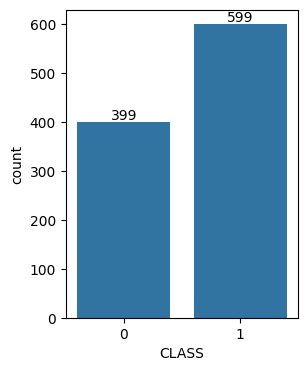

In [668]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='CLASS', data=df)
for i in ax.containers:
  ax.bar_label(i,)

In [669]:
print('Donor:', round(df['CLASS'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print('Non_Donor:', round(df['CLASS'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
# 60.02 accuracy score before implementing any model
# in this case, we can't use accuracy as the evaluation metrics

Donor: 60.02 % of the dataset
Non_Donor: 39.98 % of the dataset


In [670]:
# drop 'COMMUNICATION_PREFERENCES___PREFERRED_METHODS_OF_COMMUNICATION', 'EMAIL', 'FACEBOOK_PROFILE', 'FIRST_NAME', 'LAST_NAME', 'LINKEDIN_PROFILE', 'TWITTER_PROFILE', 'PHONE_NUMBER'
# phone number could be useful, but it might overlap with city and state. Besdies, people live in one state could use phone number form other state even other country
# other features could be useful, but it might need to be analyzed by NLP, we ignore them for now
df.drop(['COMMUNICATION_PREFERENCES___PREFERRED_METHODS_OF_COMMUNICATION', 'EMAIL', 'FACEBOOK_PROFILE', 'FIRST_NAME', 'LAST_NAME', 'LINKEDIN_PROFILE', 'TWITTER_PROFILE', 'PHONE_NUMBER'], axis=1,inplace=True)

In [671]:
display_missing(df)

AGE column missing value 17
CITY column missing value 293
EDUCATION_LEVEL column missing value 1
GENDER column missing value 53
MARITAL_STATUS column missing value 1
OCCUPATION column missing value 14
STATE column missing value 0
CLASS column missing value 0



In [672]:
def map_State_City(df):
    for index, row in df.iterrows():
        if row['STATE'] == 'CA' and row['CITY'] != 'Los Angeles':
            df.at[index,'CITY'] = 'Los Angeles'
        elif row['CITY'] == 'Los Angeles' and row['STATE'] != 'CA':
            df.at[index,'STATE'] = 'CA'
        elif row['STATE'] == 'NY' and row['CITY'] != 'New York':
            df.at[index,'CITY'] = 'New York'
        elif row['CITY'] == 'New York' and row['STATE'] != 'USA':
            df.at[index,'STATE'] = 'NY'

map_State_City(df)
df.drop('STATE', axis=1,inplace=True)
df.drop(df[df['EDUCATION_LEVEL'].isnull()].index, inplace=True)
df.drop(df[df['MARITAL_STATUS'].isnull()].index, inplace=True)
# fill NaNs with the most frequent value from one column
df['GENDER'].fillna(df['GENDER'].value_counts().index[0], inplace=True)
df['OCCUPATION'].fillna(df['OCCUPATION'].value_counts().index[0], inplace=True)
display_missing(df)

AGE column missing value 16
CITY column missing value 0
EDUCATION_LEVEL column missing value 0
GENDER column missing value 0
MARITAL_STATUS column missing value 0
OCCUPATION column missing value 0
CLASS column missing value 0



In [673]:
# get the numeric features:
numeric_columns = df.select_dtypes(include=np.number).columns
print("numeric features are:",numeric_columns)

nonnumeric_columns = df.select_dtypes(exclude=np.number).columns
print("\nnon-numeric features are:",nonnumeric_columns)

numeric features are: Index(['AGE', 'CLASS'], dtype='object')

non-numeric features are: Index(['CITY', 'EDUCATION_LEVEL', 'GENDER', 'MARITAL_STATUS', 'OCCUPATION'], dtype='object')


In [674]:
df.head()

,AGE,CITY,EDUCATION_LEVEL,GENDER,MARITAL_STATUS,OCCUPATION,CLASS
0,23.0,Los Angeles,Bachelor's degree,F,Married,Unemployed,1
1,36.0,Los Angeles,"Bachelor's degree, Journalism",M,Married,"Arts, Design, Entertainment, Sports, and Media...",1
2,25.0,Los Angeles,Bachelor of Arts,M,Single,Others,1
3,20.0,Los Angeles,Others,M,Married,"Arts, Design, Entertainment, Sports, and Media...",1
4,25.0,Los Angeles,Others,M,Single,Protective Service Occupations,1


In [675]:
print(df['MARITAL_STATUS'].unique())
df['MARITAL_STATUS'].replace('SIngle', 'Single', inplace=True)
df['MARITAL_STATUS'].unique()

['Married' 'Single' 'Others' 'SIngle']


array(['Married', 'Single', 'Others'], dtype=object)

In [676]:
df['GENDER'].unique()

array(['F', 'M'], dtype=object)

In [677]:
df.reset_index(drop=True, inplace=True)

In [678]:
# incase data leakage, we only use df to test if there is any outlier. Then use df2 to split training set and testing set
df2 = df.copy()

In [679]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
# transfering non-numeric data to numeric data
for column in nonnumeric_columns:
    df[column] = LabelEncoder().fit_transform(df[column])

In [680]:
# nonconssecutive_columns = ['CITY', 'GENDER', 'MARITAL_STATUS', 'OCCUPATION', 'STATE']

In [681]:
df

,AGE,CITY,EDUCATION_LEVEL,GENDER,MARITAL_STATUS,OCCUPATION,CLASS
0,23.0,0,2,0,0,59,1
1,36.0,0,3,1,0,2,1
2,25.0,0,1,1,2,43,1
3,20.0,0,8,1,0,2,1
4,25.0,0,8,1,2,53,1
...,...,...,...,...,...,...,...
992,61.0,1,8,0,0,28,0
993,65.0,1,8,0,0,9,0
994,56.0,1,2,0,1,53,0
995,87.0,1,8,1,2,54,0


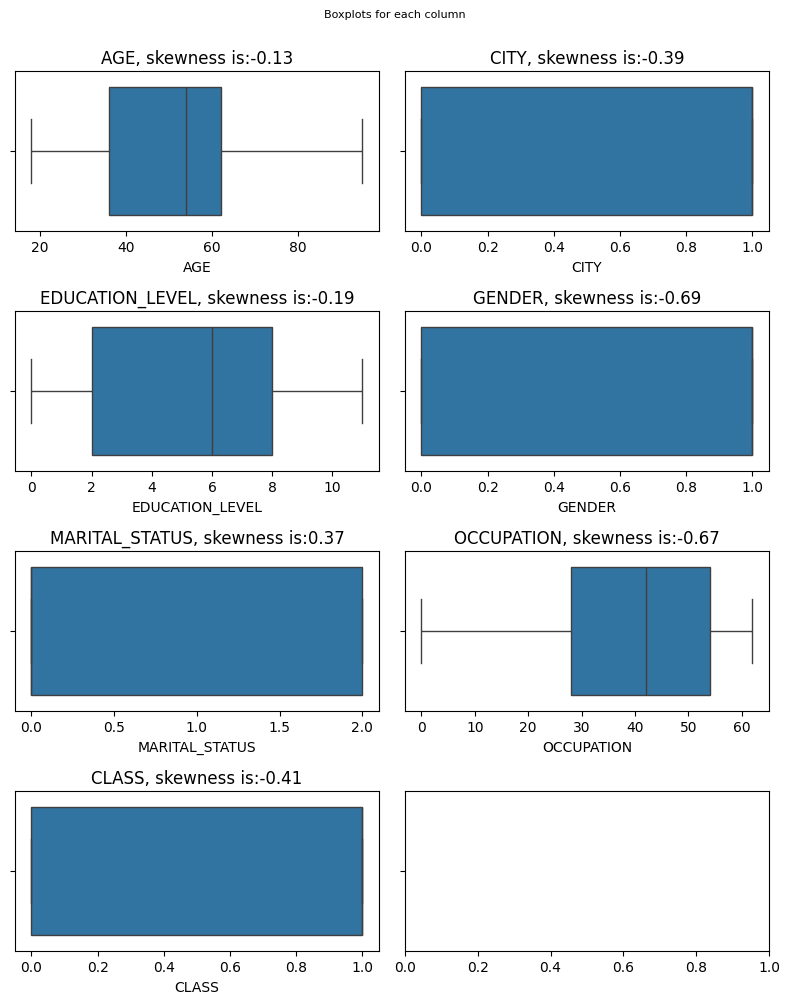

In [682]:
def boxplots_custom(dataset, column_list, rows, cols, suptitle):
  fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(8, 10))
  fig.suptitle(suptitle, y=1, size=8)

  # here axs is a two-dimensional array, need to be used in axs[1,1],
  #     in oreder to use it in axs[1], flatten it
  axs=axs.flatten()

  # dataframe.skew() function return unbiased skew over requested axis Normalized by N-1.
  #   Skewness is a measure of the asymmetry of the probability distribution of a real-valued
  #   random variable about its mean.
  for i, colname in enumerate(column_list):
    sns.boxplot(dataset[colname], orient= 'h', ax=axs[i])
    axs[i].set_title(colname + ', skewness is:' + str(round(dataset[colname].skew(axis=0, skipna=True),2)))

boxplots_custom(df, df.columns, 4, 2, 'Boxplots for each column')
plt.tight_layout()

In [683]:
# from the images above, we could find that there are no outliers, means that there are no values that are significantly different from the rest of the data.
# some images doesn't have minimum(Q1-1.5*IQR) and maximum(Q3+1.5*IQR), because no whisker will be visible if the lower quartile is equal to the minimum, or if
#   the upper quartile is equal to the maximum

In [684]:
def IQR_helper(dataset, n, column_list):
  outlier_list = []
  for colname in column_list:
    Q1 = np.percentile(dataset[colname], 25)
    Q3 = np.percentile(dataset[colname], 75)
    IQR = Q3 - Q1
    max = Q3 + 1.5 * IQR
    min = Q1 - 1.5 * IQR
    outlier_list_column = dataset[(dataset[colname] < min) | (dataset[colname] > max)].index
    outlier_list.extend(outlier_list_column)

  #print(outlier_list)
  # count how many times a sample becomes outlier
  outlier_list = Counter(outlier_list)
  #print(outlier_list)
  multiple_time_outliers = list(k for k,v in outlier_list.items() if v > n)

  out_below = dataset[dataset[colname] < min]
  out_above = dataset[dataset[colname] > max]
  print('Total number of outliers are:', out_below.shape[0] + out_above.shape[0])

  return multiple_time_outliers

In [685]:
delete_outliers = IQR_helper(df, 1, df.columns)
df_out = df.drop(delete_outliers, axis=0).reset_index(drop=True)

Total number of outliers are: 0


In [686]:
# the result correspond with what we just analyzed from these box plots

In [687]:
display_missing(df)

AGE column missing value 16
CITY column missing value 0
EDUCATION_LEVEL column missing value 0
GENDER column missing value 0
MARITAL_STATUS column missing value 0
OCCUPATION column missing value 0
CLASS column missing value 0



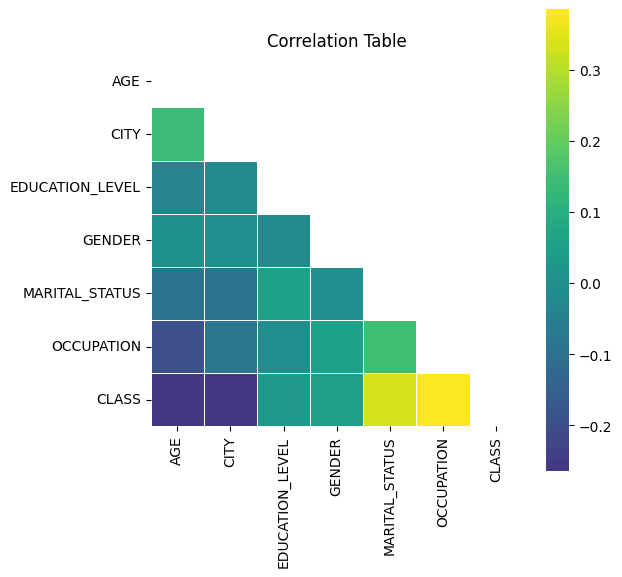

In [688]:
plt.figure(figsize = (6,6))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr, mask = mask, annot=True, robust = True, center = 0,square = True, cmap="viridis",linewidths = .6)
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, cmap="viridis",linewidths = .6)
plt.title('Correlation Table')
plt.show()

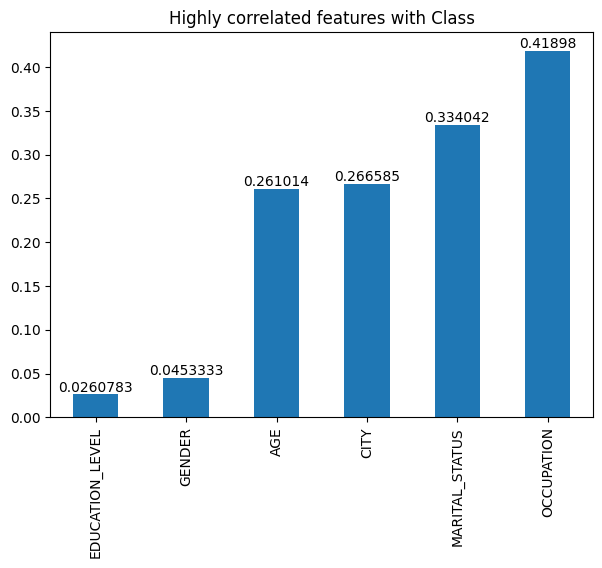

In [689]:
plt.figure(figsize=(7,5))
d = df.corr()['CLASS'][:-1].abs().sort_values().plot(kind='bar', title='Highly correlated features with Class')
for i in d.containers:
  d.bar_label(i,)

In [690]:
df

,AGE,CITY,EDUCATION_LEVEL,GENDER,MARITAL_STATUS,OCCUPATION,CLASS
0,23.0,0,2,0,0,59,1
1,36.0,0,3,1,0,2,1
2,25.0,0,1,1,2,43,1
3,20.0,0,8,1,0,2,1
4,25.0,0,8,1,2,53,1
...,...,...,...,...,...,...,...
992,61.0,1,8,0,0,28,0
993,65.0,1,8,0,0,9,0
994,56.0,1,2,0,1,53,0
995,87.0,1,8,1,2,54,0


In [691]:
df2

,AGE,CITY,EDUCATION_LEVEL,GENDER,MARITAL_STATUS,OCCUPATION,CLASS
0,23.0,Los Angeles,Bachelor's degree,F,Married,Unemployed,1
1,36.0,Los Angeles,"Bachelor's degree, Journalism",M,Married,"Arts, Design, Entertainment, Sports, and Media...",1
2,25.0,Los Angeles,Bachelor of Arts,M,Single,Others,1
3,20.0,Los Angeles,Others,M,Married,"Arts, Design, Entertainment, Sports, and Media...",1
4,25.0,Los Angeles,Others,M,Single,Protective Service Occupations,1
...,...,...,...,...,...,...,...
992,61.0,New York,Others,F,Married,Executive Director,0
993,65.0,New York,Others,F,Married,Chief Executive Officer,0
994,56.0,New York,Bachelor's degree,F,Others,Protective Service Occupations,0
995,87.0,New York,Others,M,Single,Retired,0


In [692]:
# df = df.sample(frac=1).reset_index(drop=True)
# df

In [693]:
# As df has been processed by label encoder, we use df2 to avoid data leakage
X = df2.drop('CLASS', axis=1)
y = df2['CLASS']
X

,AGE,CITY,EDUCATION_LEVEL,GENDER,MARITAL_STATUS,OCCUPATION
0,23.0,Los Angeles,Bachelor's degree,F,Married,Unemployed
1,36.0,Los Angeles,"Bachelor's degree, Journalism",M,Married,"Arts, Design, Entertainment, Sports, and Media..."
2,25.0,Los Angeles,Bachelor of Arts,M,Single,Others
3,20.0,Los Angeles,Others,M,Married,"Arts, Design, Entertainment, Sports, and Media..."
4,25.0,Los Angeles,Others,M,Single,Protective Service Occupations
...,...,...,...,...,...,...
992,61.0,New York,Others,F,Married,Executive Director
993,65.0,New York,Others,F,Married,Chief Executive Officer
994,56.0,New York,Bachelor's degree,F,Others,Protective Service Occupations
995,87.0,New York,Others,M,Single,Retired


In [694]:
y.value_counts()

1    599
0    398
Name: CLASS, dtype: int64

In [695]:
from sklearn.preprocessing import OneHotEncoder
import pickle
le = OneHotEncoder(handle_unknown='ignore')
cat_features = nonnumeric_columns.tolist()
# X = pd.get_dummies(X, columns = cat_features)
# X.head()
feature_arr = le.fit_transform(X[cat_features]).toarray()
feature_labels = le.categories_
feature_labels = np.concatenate(feature_labels)
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
# pd.concat() 函数在默认情况下会保留索引，如果 X 和 encoded_df 的索引不完全匹配，那么在进行连接时可能会导致索引重复或者缺失，从而使最终的 DataFrame 的长度不同于两者之和。
# 为了解决这个问题，您可以在进行连接时重置索引，以确保索引的连续性。具体做法是使用 ignore_index=True 参数，它会忽略原始索引，而使用默认的整数索引。
# X.reset_index(drop=True, inplace=True)
# encoded_df.reset_index(drop=True, inplace=True)
X = pd.concat([X, encoded_df], axis=1)
X.drop(cat_features, axis=1, inplace=True)
pickle.dump(le, open('oneHotEncoder.pkl','wb'))
X

,AGE,Los Angeles,New York,Associate's degree,Bachelor of Arts,Bachelor's degree,"Bachelor's degree, Journalism",Elementary school,High school,Middle school,...,Protective Service Occupations,Retired,Sales and Related Occupations,Student,Surrogate Coordinato,Transportation and Material Moving Occupations,Unemployed,Vice President,founder,nonprofit organization
0,23.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,36.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,61.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
993,65.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
994,56.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995,87.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [696]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=4)

In [697]:
display_missing(X_train)

AGE column missing value 11
Los Angeles column missing value 0
New York column missing value 0
Associate's degree column missing value 0
Bachelor of Arts column missing value 0
Bachelor's degree column missing value 0
Bachelor's degree, Journalism column missing value 0
Elementary school column missing value 0
High school column missing value 0
Middle school column missing value 0
No formal education column missing value 0
Others column missing value Others    0
Others    0
Others    0
dtype: int64
Postgraduate degree column missing value 0
Some college column missing value 0
others column missing value 0
F column missing value 0
M column missing value 0
Married column missing value 0
Others column missing value Others    0
Others    0
Others    0
dtype: int64
Single column missing value 0
American politician column missing value 0
Architecture and Engineering Occupations column missing value 0
Arts, Design, Entertainment, Sports, and Media Occupations column missing value 0
Business a

In [698]:
X_train['AGE'].fillna(X_train['AGE'].mean(), inplace=True)

In [699]:
display_missing(X_test)

AGE column missing value 5
Los Angeles column missing value 0
New York column missing value 0
Associate's degree column missing value 0
Bachelor of Arts column missing value 0
Bachelor's degree column missing value 0
Bachelor's degree, Journalism column missing value 0
Elementary school column missing value 0
High school column missing value 0
Middle school column missing value 0
No formal education column missing value 0
Others column missing value Others    0
Others    0
Others    0
dtype: int64
Postgraduate degree column missing value 0
Some college column missing value 0
others column missing value 0
F column missing value 0
M column missing value 0
Married column missing value 0
Others column missing value Others    0
Others    0
Others    0
dtype: int64
Single column missing value 0
American politician column missing value 0
Architecture and Engineering Occupations column missing value 0
Arts, Design, Entertainment, Sports, and Media Occupations column missing value 0
Business an

In [700]:
X_test['AGE'].fillna(X_test['AGE'].mean(), inplace=True)

In [701]:
# LabelEncoder it may introduce an arbitrary order to categorical values, if our data has inner order(Education level) we should avoid label encoding in Python when it introduces false order to the data
# In ordinal encoding, each unique category value is assigned an integer value. For example, “red” is 1, “green” is 2, and “blue” is 3. If we ordered our Education level to a list
#   we could use  ordinal encoding to fit on it, then transform it to our data feature.
    # from sklearn.preprocessing import OrdinalEncoder
    # enc = OrdinalEncoder(categories=[['first','second','third','forth']])
    # X = [['third'], ['second'], ['first']]
    # enc.fit(X)
    # print(enc.transform([['second'], ['first'], ['third'],['forth']]))

# from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
# # transfering non-numeric data to numeric data
# for column in nonnumeric_columns:
#   le = LabelEncoder()
#   le.fit(X_train[column])
#   X_train[column] = le.transform(X_train[column])
#   X_test[column] = le.transform(X_test[column])

In [702]:
# # Use onehot embedding to process categorical data
# from sklearn.preprocessing import OneHotEncoder
# cat_features = nonnumeric_columns.tolist()
# encoded_features_train = []
# encoded_features_test = []
# for feature in cat_features:
#     le = OneHotEncoder(handle_unknown='ignore')
#     le.fit(X_train[feature].values.reshape(-1, 1))
#     encoded_feat_train = le.transform(X_train[feature].values.reshape(-1, 1)).toarray()
#     encoded_feat_test = le.transform(X_test[feature].values.reshape(-1, 1)).toarray()
#     n = X_train[feature].nunique()
#     cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
#     encoded_df_train = pd.DataFrame(encoded_feat_train, columns=cols)
#     encoded_df_test = pd.DataFrame(encoded_feat_test, columns=cols)
#     encoded_df_train.index = X_train.index
#     encoded_df_test.index = X_test.index
#     encoded_features_train.append(encoded_df_train)
#     encoded_features_test.append(encoded_df_test)
# X_train = pd.concat([X_train, *encoded_features_train], axis=1)
# X_test = pd.concat([X_test, *encoded_features_test], axis=1)
# X_train.drop(cat_features, axis=1, inplace=True)
# X_test.drop(cat_features, axis=1, inplace=True)

In [703]:
X_train

,AGE,Los Angeles,New York,Associate's degree,Bachelor of Arts,Bachelor's degree,"Bachelor's degree, Journalism",Elementary school,High school,Middle school,...,Protective Service Occupations,Retired,Sales and Related Occupations,Student,Surrogate Coordinato,Transportation and Material Moving Occupations,Unemployed,Vice President,founder,nonprofit organization
214,78.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,52.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
966,56.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880,67.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,25.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,54.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,62.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,32.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
704,65.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [704]:
X_test

,AGE,Los Angeles,New York,Associate's degree,Bachelor of Arts,Bachelor's degree,"Bachelor's degree, Journalism",Elementary school,High school,Middle school,...,Protective Service Occupations,Retired,Sales and Related Occupations,Student,Surrogate Coordinato,Transportation and Material Moving Occupations,Unemployed,Vice President,founder,nonprofit organization
514,25.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,63.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,45.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
895,62.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
459,26.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,61.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599,54.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,62.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
693,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [705]:
len(X_test.columns.tolist())

83

In [706]:
# import seaborn as sns
# import plotly.express as px
# from matplotlib import pyplot as plt

# numeric_columns = X_train.columns.tolist()
# print(numeric_columns)
# fig = plt.figure(figsize=(20,50))
# rows, cols = 28, 3
# for idx, colname in enumerate(numeric_columns):
#   ax = fig.add_subplot(rows, cols, idx+1)
#   ax.grid(alpha=0.7, axis='both')
#   sns.kdeplot(x=colname, fill=True, color="#3386FF", linewidth=0.6, data=X_train, label='Train', warn_singular=False)
#   sns.kdeplot(x=colname, fill=True, color="#EFB000", linewidth=0.6, data=X_test, label='Test', warn_singular=False)
#   ax.set_xlabel(colname)
#   ax.legend()
# fig.tight_layout()
# fig.show()

In [707]:
# drop_cols = []
# test_sum =X_test.sum(axis=0)
# for colname in X_test.columns:
#   if test_sum[colname] == 0:
#     drop_cols.append(colname)
# drop_cols

In [708]:
# drop the columns which have obviously different distribution for train and test set
# X_train = X_train.drop(columns = drop_cols, axis=1)
# X_test = X_test.drop(columns = drop_cols, axis=1)

In [709]:
# Generate the minority class
# Oversamping data after split data to training and testing set to avoid data leakage

In [710]:
# normalize data

# from sklearn.preprocessing import StandardScaler
# def Standard_Scaler(dataset, column_list):
#   for colname in column_list:
#     data = dataset[[colname]]
#     scaler = StandardScaler().fit(dat a.values)
#     data = scaler.transform(data.values)
#     dataset[colname] = data
#   return dataset

# # Normalize AGE features as it is a consective feature
# normal_list = ['AGE']
# X_train = Standard_Scaler(X_train, normal_list)
# X_test = Standard_Scaler(X_test, normal_list)

In [711]:
# normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train['AGE'] = scaler.fit_transform(X_train[['AGE']])
X_test['AGE'] = scaler.transform(X_test[['AGE']])
pickle.dump(scaler, open('StandardScaler.pkl','wb'))

In [712]:
X_train

,AGE,Los Angeles,New York,Associate's degree,Bachelor of Arts,Bachelor's degree,"Bachelor's degree, Journalism",Elementary school,High school,Middle school,...,Protective Service Occupations,Retired,Sales and Related Occupations,Student,Surrogate Coordinato,Transportation and Material Moving Occupations,Unemployed,Vice President,founder,nonprofit organization
214,1.788759,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.063405,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
966,0.328844,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880,1.058802,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843,-1.728309,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,0.196124,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,0.727003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,-1.263791,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
704,0.926082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [713]:
y_test

514    1
797    0
29     1
895    0
459    1
      ..
992    0
599    0
105    1
693    0
444    1
Name: CLASS, Length: 200, dtype: int64

In [714]:
# Use Stratified K-Fold Cross Validation to create stratified subsamples that preserve the class frequencies in the individual folds
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [715]:
# # Oversample/undersample
# # same idea, do it before cross validating to avoid data leakage

# from imblearn.over_sampling import SMOTE
# ros = SMOTE(random_state=42)
# X_over, y_over = ros.fit_resample(X_train, y_train)
# print('y_over is:\n', y_over.value_counts())

In [716]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

smote_pipeline = make_pipeline(SMOTE(random_state=42),
                               RandomForestClassifier(n_estimators=100, random_state=13))
score = cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall Scores are: [0.92708333 0.90625    0.94791667 0.9375     0.95789474]
Average Cross Validation Recall score: 0.935328947368421


In [717]:
# # GridSearchCV
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6],
    'random_state': [13]
}

new_params = {'randomforestclassifier__' + key: params[key] for key in params}
smote_rf = GridSearchCV(smote_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
smote_rf.fit(X_train, y_train)

print('Best parameters:', smote_rf.best_params_)
print('Best score:', smote_rf.best_score_)

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
# Confusion matrix and scores
y_pred = smote_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)

smote_rf_Recall = recall_score(y_test, y_pred)
smote_rf_Precision = precision_score(y_test, y_pred)
smote_rf_f1 = f1_score(y_test, y_pred)
smote_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

ndf = [(smote_rf_Recall, smote_rf_Precision, smote_rf_f1, smote_rf_accuracy)]

smote_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
smote_rf_score.insert(0, 'Random Forest with', 'SMOTETomek')
smote_rf_score

Best parameters: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 13}
Best score: 0.9061184210526315
[1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0
 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1
 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1
 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0
 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1
 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1]
[[ 74   6]
 [  8 112]]


,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,SMOTETomek,0.933333,0.949153,0.941176,0.93


In [718]:
import pickle
pickle.dump(smote_rf.best_estimator_.named_steps['randomforestclassifier'], open('smote_rf.pkl', 'wb'))

In [719]:
smote_model = pickle.load(open('smote_rf.pkl', 'rb'))
oneHotEncoder = pickle.load(open('oneHotEncoder.pkl', 'rb'))
standardScaler=pickle.load(open('StandardScaler.pkl', 'rb'))

In [720]:
testdata =df2.drop('CLASS', axis=1).head(1)
category_features = ['CITY', 'EDUCATION_LEVEL', 'GENDER', 'MARITAL_STATUS', 'OCCUPATION']
testdata

,AGE,CITY,EDUCATION_LEVEL,GENDER,MARITAL_STATUS,OCCUPATION
0,23.0,Los Angeles,Bachelor's degree,F,Married,Unemployed


In [721]:
feature_arr = oneHotEncoder.transform(testdata[category_features]).toarray()
feature_labels = oneHotEncoder.categories_
feature_labels = np.concatenate(feature_labels)
encoded_df = pd.DataFrame(feature_arr, columns=feature_labels)
testdata = pd.concat([testdata, encoded_df], axis=1)
testdata.drop(category_features, axis=1, inplace=True)
testdata['AGE'] = standardScaler.transform(testdata[['AGE']])
output = smote_model.predict(testdata)
output

array([1])

AUC-ROC Curve for Random Forest with Class weights: 0.9292


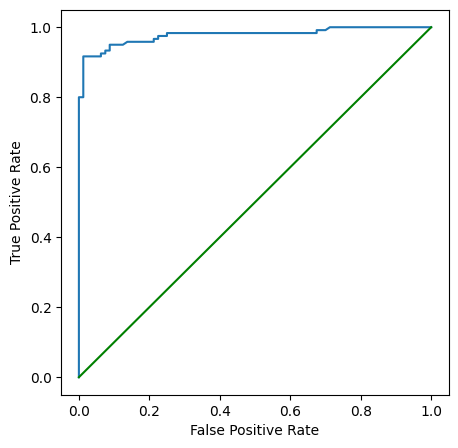

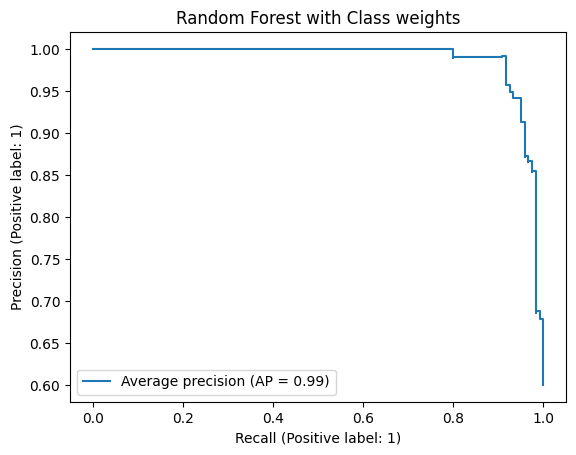

In [722]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with Class weights: {ROCAUCscore:.4f}")

y_proba = smote_rf.best_estimator_.named_steps['randomforestclassifier'].predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    smote_rf, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Random Forest with Class weights")



feature importance:


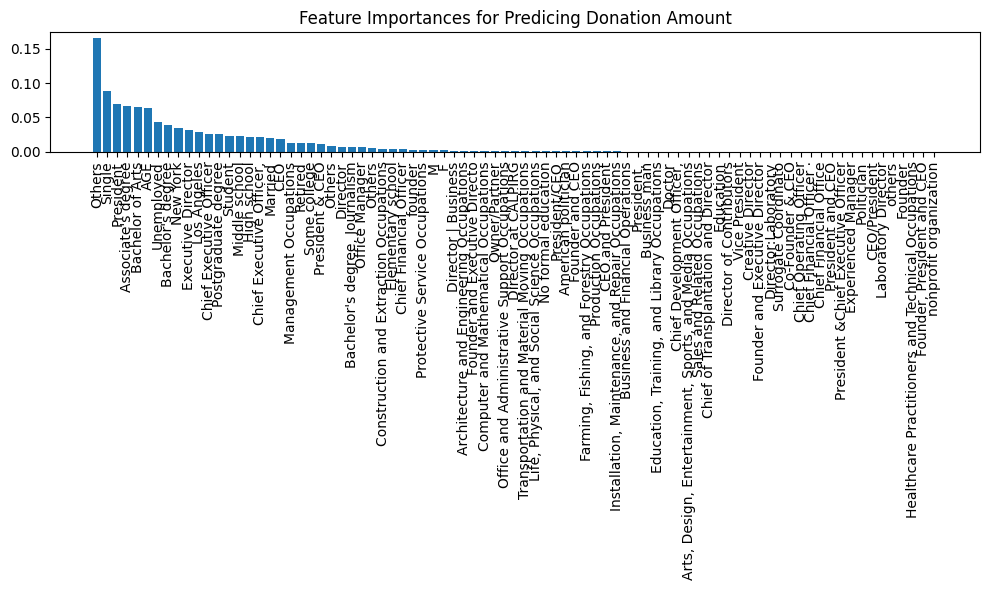

In [723]:
print("\nfeature importance:")
importances = smote_rf.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns.tolist()

# Sort feature importances in descending order and get the feature indices
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
feature_names = [feature_names[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances for Predicing Donation Amount")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90)
plt.tight_layout()
plt.show()

In [724]:
data=pd.concat([pd.concat([X_train, y_train],axis=1), pd.concat([X_test, y_test],axis=1)])

In [725]:
# MARITAL_STATUS_1 --- maried, MARITAL_STATUS_2 --- others, MARITAL_STATUS_3 --- single
# plt.figure(figsize=(5,5))
# sns.jointplot(x='MARITAL_STATUS_3', y='AGE',hue='CLASS', data=data, palette='dark', s=9)

In [726]:
# plt.figure(figsize=(5,5))
# sns.jointplot(x='MARITAL_STATUS_1', y='AGE',hue='CLASS', data=data, palette='dark', s=9)

In [727]:
# Another way is using weighted model to against unbalanced data

In [728]:
weighted_rf = RandomForestClassifier(n_estimators=100, random_state=13, class_weight='balanced')

score2 = cross_val_score(weighted_rf, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.9375     0.90625    0.94791667 0.94791667 0.94736842]
Average Cross Validation Recall score: 0.937390350877193


In [729]:
# # GridSearchCV
from sklearn.model_selection import GridSearchCV

grid_weighted_rf = GridSearchCV(weighted_rf, param_grid=params, cv=kf, scoring='recall')
grid_weighted_rf.fit(X_train, y_train)

print('Best parameters:', grid_weighted_rf.best_params_)
print('Best score:', grid_weighted_rf.best_score_)

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
# Confusion matrix and scores
y_pred = grid_weighted_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

grid_weighted_rf_Recall = recall_score(y_test, y_pred)
grid_weighted_rf_Precision = precision_score(y_test, y_pred)
grid_weighted_rf_f1 = f1_score(y_test, y_pred)
grid_weighted_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

ndf = [(grid_weighted_rf_Recall, grid_weighted_rf_Precision, grid_weighted_rf_f1, grid_weighted_rf_accuracy)]

grid_weighted_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_weighted_rf_score.insert(0, 'Random Forest with', 'Weight Random Forest')
grid_weighted_rf_score

Best parameters: {'max_depth': 6, 'n_estimators': 50, 'random_state': 13}
Best score: 0.8977631578947367
[[ 74   6]
 [  7 113]]


,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Weight Random Forest,0.941667,0.94958,0.945607,0.935


AUC-ROC Curve for Random Forest with Class weights: 0.9333


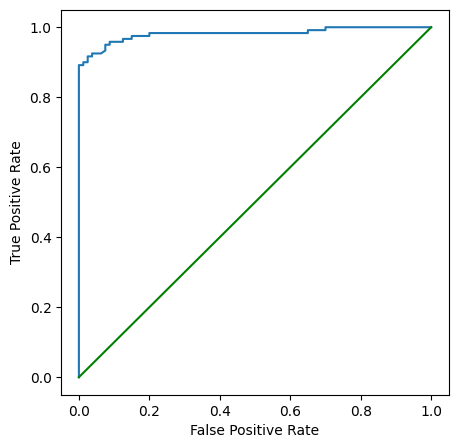

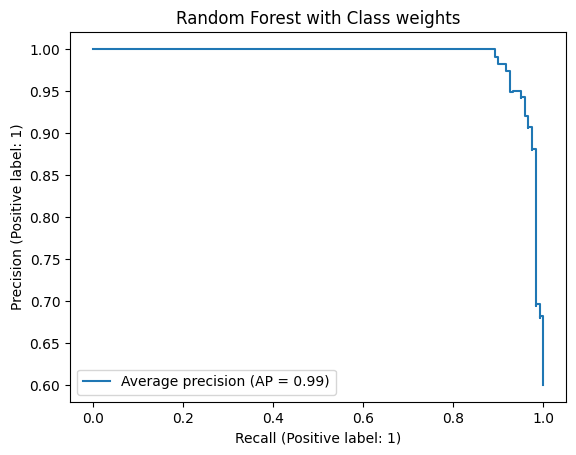

In [730]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with Class weights: {ROCAUCscore:.4f}")

y_proba = grid_weighted_rf.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    grid_weighted_rf, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Random Forest with Class weights")